In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# check if a GPU is available
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE

'cpu'

## MD step function

In [4]:
def energy_lj(r: torch.tensor, epsilon: float = 1.0, sigma: float = 1.0):
    """Compute the Lennard-Jones energy of a system with positions r

    Parameters
    ----------
    r: atomic configuration

    sigma: LJ potential parameter sigma, default 1.0

    epsilon: LJ potential parameter epsilon, default 1.0

    Return
    ------
    ene: total LJ energy of atomic configuration

    """
    def lj(dist, epsilon: float = 1.0, sigma: float = 1.0):
        return 4 * epsilon * ((sigma / dist)**12 - (sigma / dist)**6)

    distances = F.pdist(r)

    pair_energies = torch.vmap(lj)(distances)

    return torch.sum(pair_energies)

def energy_kinetic(v: torch.tensor, m: float = 1.0):
    """
    Compute the kinetic energy of a system 
    """
    
    return 0.5 * m * torch.sum(torch.square(v))

In [5]:
def get_forces(energy_fn: callable, r: torch.Tensor):

    """Computes the forces acting on a configuration r for a given energy function using backpropagation.

    Parameters
    ----------
    r: atomic configuration

    energy_fn: energy function


    Return
    ------
    f: atomic forces
    """

    assert r.requires_grad == False

    r.requires_grad = True

    # evaluate energy
    energy = energy_fn(r)

    # compute gradients w.r.t. r
    energy.backward()

    # get gradients w.r.t. r
    forces = -r.grad

    r.requires_grad = False
    return forces

In [6]:
def verlet_step(
    r: torch.tensor,
    v: torch.tensor,
    f: torch.tensor,
    energy_fn: callable,
    dt: float,
    m: float = 1.0,
):
    """velocity Verlet step: MD in NVE ensemble.

    Parameters
    ----------
    r: positions

    v: velocities

    f: forces

    dt: time step

    m: mass

    energy_fn: energy function

    Return
    ------
    r: updated position

    v: updated velocities

    f: updated forces


    """
    # Remove center of mass motion
    com = torch.mean(v, axis=0)
    v -= com

    # update velocity 1/2 step
    v += 0.5 * f / m * dt

    # update positions
    r = r + v * dt

    f = get_forces(energy_fn, r)

    # update velocity 1/2 step
    v += 0.5 * f / m * dt

    return r, v, f


## Example MD run

In [7]:
d = 1.1

# 3d cluster
clus3d = torch.tensor(
    [
        [0.0, 0.0, 0.0],
        [d / np.sqrt(2.), d / np.sqrt(2), 0.0],
        [-d / np.sqrt(2), d / np.sqrt(2), 0.0],
        [d / np.sqrt(2), -d / np.sqrt(2), 0.0],
        [-d / np.sqrt(2), -d / np.sqrt(2), 0.0],
        [0, 0, d],
        [0, 0, -d],
    ],dtype=torch.float32
)

In [8]:
def assign_MBv(n_particles, beta, m: float = 1.0):
    """Assign Maxwell-Boltzmann distributed velocities.

    Parameters
    ----------
    v: velocity array

    beta: 1/ (kB * T)

    m: atomic mass


    Return
    ------
    v:     velocity array

    """

    v = torch.normal(mean=0, std=np.sqrt(1.0 / (beta * m)), size=(n_particles, 3))

    return v

In [9]:
r = torch.clone(clus3d)

n_particles = len(r)

# compute LJ energy
energy = energy_lj(clus3d)

# set inverse temp \beta = 1 / (kB * T)
beta = 100.0
m = 1.0

dt = 1e-3
n_dimensions = r.shape[-1]

In [10]:
# initialize number of MD steps
n_steps = 1000

n_log = 50

# energies
potential_energies = torch.empty((n_steps // n_log, 1))
positions = torch.empty((n_steps // n_log, n_particles, n_dimensions))

In [11]:
# assign intial structure
r = torch.clone(clus3d)

# assign intial MB velocities
v = assign_MBv(n_particles, beta, m)

# compute initial forces
f = get_forces(energy_lj, r)


In [12]:
# run velocity Verlet
for i in range(n_steps):
    if i % n_log == 0:
        positions[i // n_log] = r
        potential_energies[i // n_log] = energy_lj(r)

    r, v, f = verlet_step(r, v, f, energy_lj, dt, m)

## 1.1 MD Simulation

For a cluster consisting of 7 particles, run an MD simulation for 100 000 steps and store the
positions of the particles and the corresponding potential energies as well as the kinetic energies
every 50 steps so that your dataset contains 2000 pairs positions-energy

In [13]:
# assign intial structure
r = torch.clone(clus3d)

# assign intial MB velocities
v = assign_MBv(n_particles, beta, m)

# compute initial forces
f = get_forces(energy_lj, r)

n_log = 50
n_dimensions = r.shape[-1]
n_particles = len(r)
n_steps = int(1e5)
print(f"{n_particles=}")

potential_energies = torch.empty((n_steps // n_log, 1))
kinetic_energies = torch.empty((n_steps // n_log, 1))

positions = torch.empty((n_steps // n_log, n_particles, n_dimensions))
velocities = torch.empty((n_steps // n_log, n_particles, n_dimensions))


# set inverse temp \beta = 1 / (kB * T)
beta = 100.0
m = 1.0

dt = 1e-3


for i in range(n_steps):
    if i % n_log == 0:
        positions[i // n_log] = r
        potential_energies[i // n_log] = energy_lj(r)
        kinetic_energies[i // n_log] = energy_kinetic(v)
    r, v, f = verlet_step(r, v, f, energy_lj, dt, m)


n_particles=7


Plot a histogram of the potential energy values and plot
the total energy as a function of time.

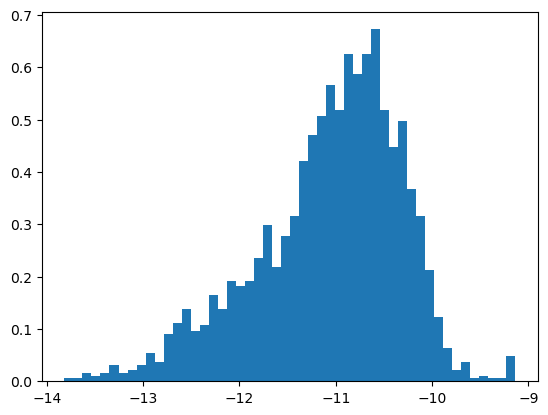

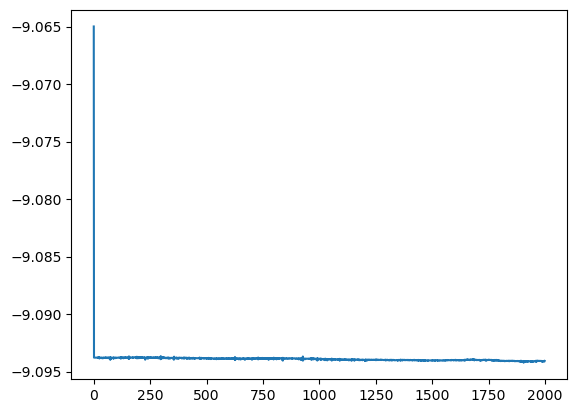

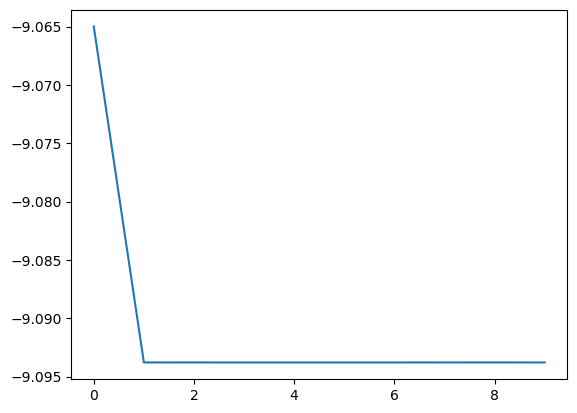

Energy fluctuation: np.var(E_tot[1:])=9.831318e-09


In [14]:
plt.figure()
plt.hist(potential_energies.numpy(), bins=50, density=True)
plt.show()

E_tot = potential_energies.numpy() + kinetic_energies.numpy()
plt.figure()
plt.plot(E_tot)
plt.show()

plt.figure()
plt.plot(E_tot[:10])
plt.show()

print(f"Energy fluctuation: {np.var(E_tot[1:])=}")

Q: How many steps does the system need to equilibrate?
Is the energy conserved? How large are the fluctuations?

A: 1 step (Amazing!) Yes, the energy is conserved. The total energy fluctuation is 2.5430482e-09.

## 1.2 Dataset


Q: Why use sorted pairwise distances?

A: Because the total energy (or more specifically, the potential energy) is independent of the order of the pairwise distances. It's a sum over all pairewise distances (Eq. 2)

Create Datasets for testing and training and a training DataLoader using the
sorted pairwise distances as features (x-values) and the energies as labels (y-values).

In [16]:
sorted_pairwise_distances =  np.array([torch.sort(F.pdist(pos))[0].numpy() for pos in positions])
print(f"{sorted_pairwise_distances.shape=}")
print(f"{potential_energies.numpy().shape=}")

from utils import split_data
from torch.utils.data import DataLoader

# Datasets
## Pairwise distances -> Energy
batch_size = 32

all_data_dist, train_data_dist, test_data_dist = split_data(sorted_pairwise_distances, potential_energies.numpy(), train_fraction=.75, device= DEVICE)
trainloader_dist = DataLoader(train_data_dist, 
                         batch_size=batch_size, 
                         shuffle=True)
testloader_dist = DataLoader(test_data_dist, 
                         batch_size=batch_size, 
                         shuffle=True)

sorted_pairwise_distances.shape=(2000, 21)
potential_energies.numpy().shape=(2000, 1)


## 1.3 Fitting the NN potential

In [46]:
from utils import train, MLP
from itertools import product
from tqdm import trange
from torch import nn
from torchmetrics.functional import mean_squared_error



n_epochs = 1000
no_of_hidden_layers = np.array([4,8,12])
no_of_nodes = np.arange(100, step=20) + 1
learning_rate = 1e-4
criterion = nn.MSELoss()


for NN in product(no_of_hidden_layers, no_of_nodes):
    dim_hidden_layers, dim_nodes = NN
    dimensions = [sorted_pairwise_distances.shape[1]] + [dim_nodes]*dim_hidden_layers + [1]
    model_dist = MLP(n_units=dimensions).to(DEVICE)
    optimizer = torch.optim.Adam(model_dist.parameters(), lr=learning_rate) # stochastic gradient descent


    for epoch in trange(n_epochs):

        train(model_dist, trainloader_dist, optimizer, criterion, device=DEVICE)

    with torch.no_grad():
        E_pred_dist = model_dist(torch.from_numpy(test_data_dist.x))
    
    print(f'{dim_hidden_layers=}; {dim_nodes=}')
    mse_test = mean_squared_error(torch.from_numpy(test_data_dist.y), E_pred_dist)
    print(f'MSE  on test set: {mse_test}')

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:26<00:00, 38.29it/s]


dim_hidden_layers=4; dim_nodes=1
MSE  on test set: 25.483455657958984


100%|██████████| 1000/1000 [00:28<00:00, 35.61it/s]


dim_hidden_layers=4; dim_nodes=21
MSE  on test set: 0.00038371619302779436


100%|██████████| 1000/1000 [00:30<00:00, 32.33it/s]


dim_hidden_layers=4; dim_nodes=41
MSE  on test set: 5.326073005562648e-05


100%|██████████| 1000/1000 [01:49<00:00,  9.10it/s]


dim_hidden_layers=4; dim_nodes=61
MSE  on test set: 8.290757978102192e-05


100%|██████████| 1000/1000 [01:56<00:00,  8.57it/s]


dim_hidden_layers=4; dim_nodes=81
MSE  on test set: 1.4578511581930798e-05


100%|██████████| 1000/1000 [00:36<00:00, 27.43it/s]


dim_hidden_layers=8; dim_nodes=1
MSE  on test set: 21.023666381835938


100%|██████████| 1000/1000 [00:39<00:00, 25.05it/s]


dim_hidden_layers=8; dim_nodes=21
MSE  on test set: 1.4974855730542913e-05


100%|██████████| 1000/1000 [00:45<00:00, 21.99it/s]


dim_hidden_layers=8; dim_nodes=41
MSE  on test set: 1.1766725037887227e-05


100%|██████████| 1000/1000 [02:41<00:00,  6.17it/s]


dim_hidden_layers=8; dim_nodes=61
MSE  on test set: 5.309541847964283e-06


100%|██████████| 1000/1000 [03:50<00:00,  4.34it/s] 


dim_hidden_layers=8; dim_nodes=81
MSE  on test set: 6.110365211497992e-05


100%|██████████| 1000/1000 [00:46<00:00, 21.59it/s]


dim_hidden_layers=12; dim_nodes=1
MSE  on test set: 22.42813491821289


100%|██████████| 1000/1000 [00:52<00:00, 19.10it/s]


dim_hidden_layers=12; dim_nodes=21
MSE  on test set: 1.654832885833457e-05


100%|██████████| 1000/1000 [01:02<00:00, 15.89it/s]


dim_hidden_layers=12; dim_nodes=41
MSE  on test set: 3.187542097293772e-05


100%|██████████| 1000/1000 [03:43<00:00,  4.48it/s]


dim_hidden_layers=12; dim_nodes=61
MSE  on test set: 1.396919287799392e-06


100%|██████████| 1000/1000 [06:04<00:00,  2.74it/s]


dim_hidden_layers=12; dim_nodes=81
MSE  on test set: 8.61201169755077e-06


An optimal NN has: 12 hidden layers and 61 nodes/layer  


100%|██████████| 2000/2000 [06:15<00:00,  5.33it/s]


First round:
MSE  on test set: 0.027420228347182274


100%|██████████| 2000/2000 [04:00<00:00,  8.30it/s]


Second round:
MSE  on test set: 0.005835852585732937


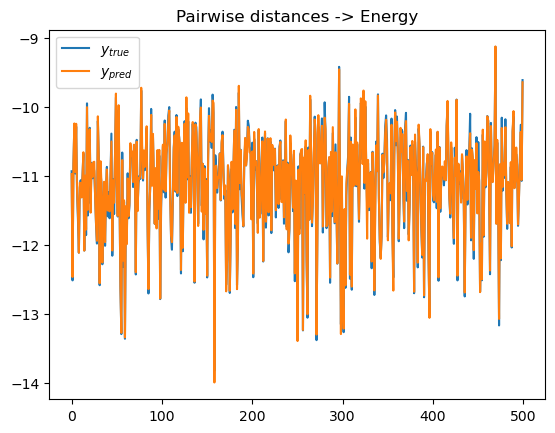

In [17]:
from utils import train, MLP
from itertools import product
from tqdm import trange
from torch import nn
from torchmetrics.functional import mean_squared_error

print(f"An optimal NN has: 12 hidden layers and 61 nodes/layer  ")

learning_rate = [1e-3, 1e-4]
criterion = nn.MSELoss()
n_epochs = 2000

dim_hidden_layers, dim_nodes = 8, 50
dimensions = [sorted_pairwise_distances.shape[1]] + [dim_nodes]*dim_hidden_layers + [1]
model_dist = MLP(n_units=dimensions).to(DEVICE)

optimizer = torch.optim.Adam(model_dist.parameters(), lr=learning_rate[0])
for epoch in trange(n_epochs):
    train(model_dist, trainloader_dist, optimizer, criterion, device=DEVICE)
with torch.no_grad():
    E_pred_dist = model_dist(torch.from_numpy(test_data_dist.x))
print(f"First round:")
mse_test = mean_squared_error(torch.from_numpy(test_data_dist.y), E_pred_dist)
print(f"MSE  on test set: {mse_test}")

optimizer = torch.optim.Adam(model_dist.parameters(), lr=learning_rate[1])
for epoch in trange(n_epochs):
    train(model_dist, trainloader_dist, optimizer, criterion, device=DEVICE)
with torch.no_grad():
    E_pred_dist = model_dist(torch.from_numpy(test_data_dist.x))
print(f"Second round:")
mse_test = mean_squared_error(torch.from_numpy(test_data_dist.y), E_pred_dist)
print(f"MSE  on test set: {mse_test}")

plt.figure()
plt.title('Pairwise distances -> Energy')
plt.plot(test_data_dist.y, label=r'$y_{true}$')
plt.plot(E_pred_dist.detach().numpy(), label=r'$y_{pred}$')
plt.legend()
plt.show()



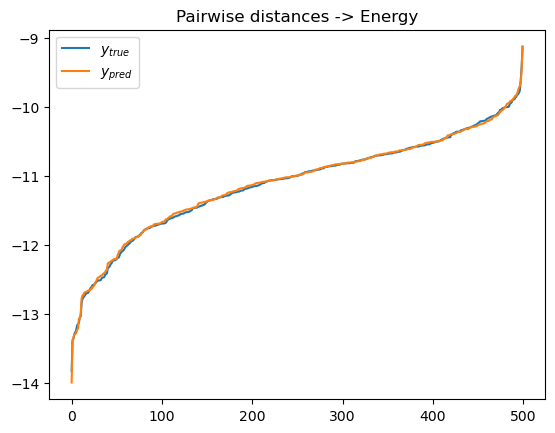

In [18]:
# Energy sorting

plt.figure()
plt.title('Pairwise distances -> Energy')
plt.plot(np.sort(test_data_dist.y, axis=0), label=r'$y_{true}$')
plt.plot(np.sort(E_pred_dist.detach().numpy(), axis=0), label=r'$y_{pred}$')
plt.legend()
plt.show()

Hmm similar situation to the energy prediction case using featurization...

## 1.4 Running MD with the NN potential

In [30]:
def energy_model(r: torch.tensor) -> float:
    """
    Computes the sorted pairwise distances of one configuration, evaluates
    the NN potential on the pairwise distances and returns the energy prediction of the model
    """

    sorted_pairwise_distances =  np.array(torch.sort(F.pdist(r))[0].numpy())
    E_pred = model_dist(torch.from_numpy(sorted_pairwise_distances)).detach().numpy()

    return E_pred[0]

E_pot = potential_energies.numpy().reshape(-1)
np.abs(E_pot - np.mean(E_pot)).argmin()
print(f"Index of configuration with energy close to the mean energy: {np.abs(E_pot - np.mean(E_pot)).argmin()}")

Index of configuration with energy close to the mean energy: 1377


Use the energy_model function to run an MD simulation for 50 000 steps and store the energies
every 25 steps.

In [41]:
# assign intial structure
r = positions[1377]

# assign intial MB velocities
v = velocities[1377]

# compute initial forces
f = get_forces(energy_lj, r)

n_log = 50
n_dimensions = r.shape[-1]
n_particles = len(r)
n_steps = int(1e5)

E_tot = []
E_pot = []

# set inverse temp \beta = 1 / (kB * T)
beta = 100.0
m = 1.0

dt = 1e-3


for _ in trange(2000):
    for _ in range(25): 
        r, v, f = verlet_step(r, v, f, energy_lj, dt, m)
    
    e_pot = energy_model(r)
    E_pot.append(e_pot)
    E_tot.append(e_pot + energy_kinetic(v).numpy())

  0%|          | 0/2000 [00:00<?, ?it/s]

100%|██████████| 2000/2000 [00:07<00:00, 282.53it/s]


Plot a histogram of the potential energy values and
plot the total energy as a function of time and compare to the plots you obtained in 1.1. 

[-11.063757, -10.931653, -10.8247, -10.677645, -10.647837, -10.769785, -10.97617, -11.276971, -11.418564, -11.500668, -11.594341, -11.6806, -11.7779875, -11.818426, -11.887998, -11.945958, -11.965664, -11.699641, -11.518944, -11.755045, -11.939897, -12.075266, -11.848407, -11.404911, -11.0915165, -10.949195, -10.831658, -10.769667, -10.811218, -10.955924, -11.217983, -11.429526, -11.30448, -11.20182, -10.989622, -10.89369, -11.038509, -11.314716, -11.34013, -11.50087, -11.789383, -11.936178, -12.070219, -12.171053, -12.1640415, -12.064251, -11.788718, -11.250195, -10.83518, -10.685281, -10.93659, -11.2527485, -11.395367, -11.262833, -11.149829, -11.040726, -10.958101, -10.890251, -10.793544, -10.6909485, -10.643784, -10.696489, -10.834921, -11.077516, -11.301725, -11.4643955, -11.502563, -11.436843, -11.337943, -11.27053, -11.338019, -11.4563675, -11.421141, -11.306454, -11.163154, -11.088195, -11.059863, -11.085563, -11.116279, -11.1899185, -11.392977, -11.555401, -11.693937, -11.6484

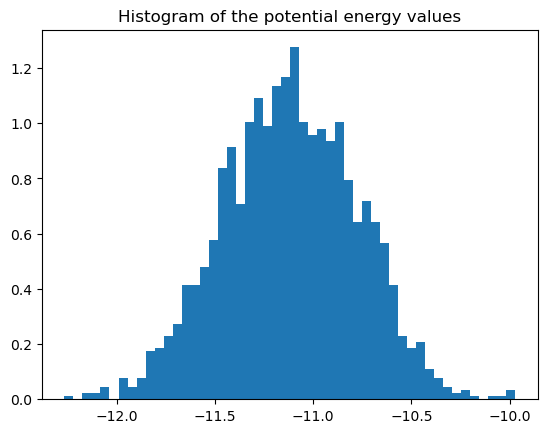

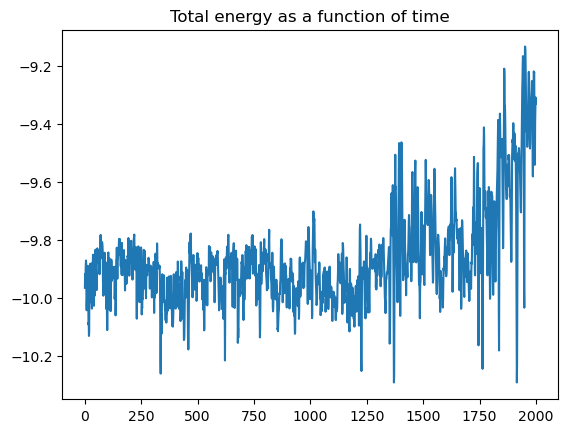

Energy fluctuation: np.var(E_tot)=0.027553326


In [42]:
plt.figure()
plt.hist(E_pot, bins=50, density=True)
plt.title("Histogram of the potential energy values")
plt.show()

plt.figure()
plt.plot(E_tot)
plt.title("Total energy as a function of time")
plt.show()

print(f"Energy fluctuation: {np.var(E_tot)=}")

The total energy fluctuation is 0.027553326. The total energy is not well-conserved ... The energy landscape is very high-dimensional so the learned potential energy function might not be well-behaved. 